# Imports

In [16]:
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')

In [17]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
import matplotlib.animation as animation

### Directories

In [3]:
testdir = "/home/darren/Desktop/plots/"
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"
date = "/6-20/"

### Some global initial parameters for B dist

In [4]:
#DO NOT CHANGE ON THIS DOCUMENT
start_point = 3
end_point = 14
initial_B = 50 #(rougly 1% distortion at z = 3.0, 0% at z = 14)
final_B = 0

### Define Distorted B Field

In [5]:
#MU2E FIELD
df_Mu2e = pd.read_pickle(mapdir+"Mu2e_DSMap_V13.p")
B_Mu2e_func = get_df_interp_func(mapdir+"Mu2e_DSMap_V13.p", gauss=False)

#MU2E FIELD + DIS
df_Mu2e_dis = get_B_df_distorted(df_Mu2e, v="0", Bz0 = initial_B, Bzf = 0, z0 = start_point, zf = end_point)
B_Mu2e_dis = get_df_interp_func(df=df_Mu2e_dis, gauss=False)

In [6]:
(df_Mu2e)

#Bz(in tracking region is 1 tesla)

,X,Y,Z,Bx,By,Bz,R,Phi,Bphi,Br
0,-1.2,-1.2,3.071,1284.125788,1307.100001,442.195248,1.697056,-2.356194,-16.245222,-1832.273327
1,-1.2,-1.2,3.096,1312.127380,1335.143291,410.874370,1.697056,-2.356194,-16.274707,-1871.903043
2,-1.2,-1.2,3.121,1339.646202,1362.701661,376.958648,1.697056,-2.356194,-16.302671,-1910.848499
3,-1.2,-1.2,3.146,1366.531533,1389.624290,340.379319,1.697056,-2.356194,-16.329045,-1948.896473
4,-1.2,-1.2,3.171,1392.610688,1415.737061,301.071838,1.697056,-2.356194,-16.352815,-1985.801737
...,...,...,...,...,...,...,...,...,...,...
4902084,1.2,1.2,15.971,205.452081,204.896327,362.118995,1.697056,0.785398,-0.392978,290.160142
4902085,1.2,1.2,15.996,200.959435,200.443981,358.156213,1.697056,0.785398,-0.364481,283.835077
4902086,1.2,1.2,16.021,196.581608,196.105341,354.221831,1.697056,0.785398,-0.336772,277.671604
4902087,1.2,1.2,16.046,192.315417,191.877252,350.317143,1.697056,0.785398,-0.309830,271.665242


### Simple Visualize B Field

Text(0, 0.5, 'B (gauss)')

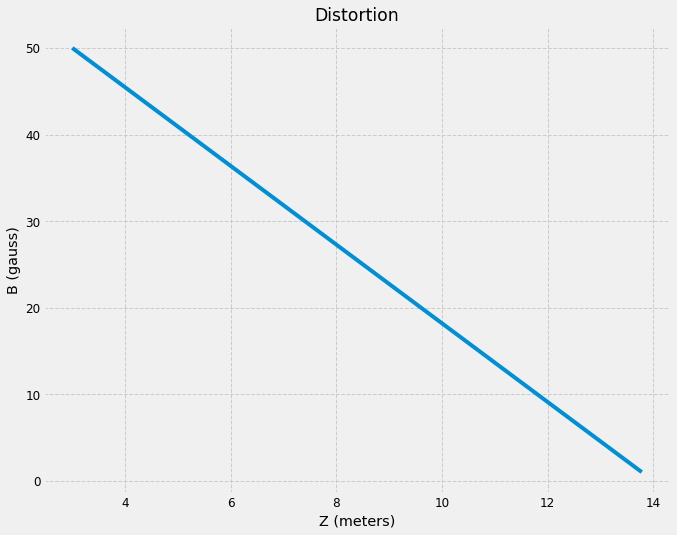

In [7]:
m = (final_B - initial_B) / (end_point - start_point)
n = 50
step = (end_point - start_point) / n
t = np.arange(start_point, end_point, step)
x = plt.plot(t, ((t - start_point)*m) + initial_B)
plt.title("Distortion")
plt.xlabel("Z (meters)")
plt.ylabel("B (gauss)")

# Functions

In [8]:
#input N, return N random values between 0 and 2pi
def get_random_phi(N):
    phis = np.random.uniform(0, 2*math.pi, N)
    return phis

In [9]:
#input N, return N equally spaced values between 0 and 2pi
def get_uniform_phi(N):
    phis = np.linspace(0, 2*math.pi, N)
    return phis

In [10]:
#input list of phis, number of steps for integrator, initial position / return dataframe trajectory
def run_solver(phi, N_calc, field, xnaught, ynaught, znaught, name):
    ic_Mu2e = InitConds(t0=0., tf=4e-8, N_t=N_calc,
                    x0=xnaught, y0=ynaught, z0=znaught,
                    p0=104.96, theta0=np.pi/3, phi0=phi)
    e_solver = trajectory_solver(ic_Mu2e, B_func=field, bounds=bounds_Mu2e)
    sol = e_solver.solve_trajectory(verbose = False, atol=1e-10, rtol=1e-10) # high tolerance so it runs quickly for testing
    e_solver.dataframe['r'] = ((e_solver.dataframe['x'])**2 + (e_solver.dataframe['y'])**2)**(1/2)
    e_solver.to_pickle(datadir+f'50_Gauss_z_3-14/{phi}_{name}.pkl')
    
    return e_solver.dataframe

In [11]:
def plot3d(phi, N_calc, xnaught, ynaught, znaught):
    ic_Mu2e = InitConds(t0=0., tf=4e-8, N_t=N_calc, x0=xnaught, y0=ynaught, z0=znaught, p0=104.96, theta0=np.pi/3, phi0=phi)
    
    e_solver = trajectory_solver(ic_Mu2e, B_func = B_Mu2e_func, bounds=bounds_Mu2e)
    e_Mu2e = e_solver.solve_trajectory(verbose = False, atol=1e-10, rtol=1e-10)
   
    e_solver_bounce = trajectory_solver(ic_Mu2e, B_func = B_Mu2e_dis, bounds=bounds_Mu2e)
    e_Mu2e_bounce = e_solver_bounce.solve_trajectory(verbose = False, atol=1e-10, rtol=1e-10)
    
    #fig, ax = e_Mu2e.plot3d()
    #fig, ax = e_Mu2e_bounce.plot3d(fig = fig, ax = ax, cmap = 'hot')
    
    return e_solver, e_solver_bounce
e, f = plot3d(2.0, 20000, 0.054094482, 0.03873037, 5.988900879)

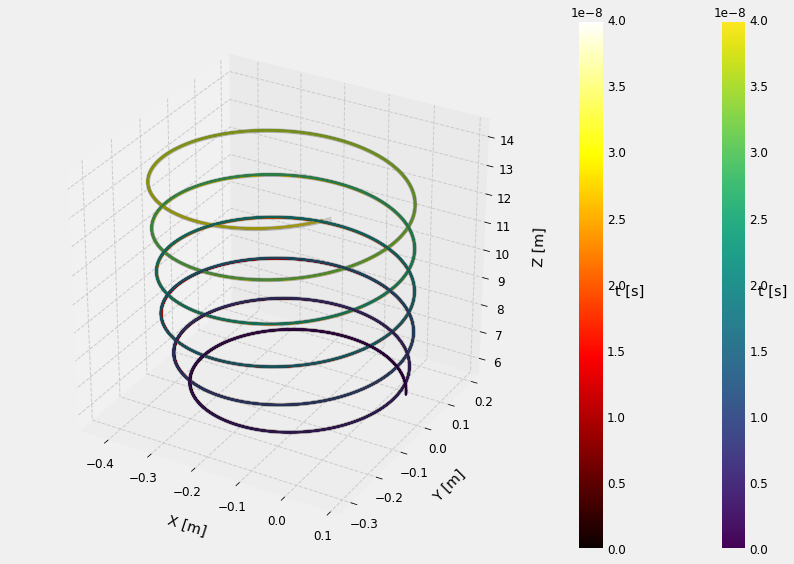

In [12]:
fig, ax = e.plot3d()
fig, ax = f.plot3d(fig=fig, ax=ax, cmap ='hot')

In [13]:
#input previous dataframe of trajectory, any z value / return new dataframe with x, y, z, t, r values at a z
def find_track_at_z(df, z): 
    delta = 10/4001   #approximate z range divided by number of points
    mask = (df.z < z + delta) & (df.z > z - delta)
    
    while (len(df.z[mask]) > 2):
        delta = delta / 2
        mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) == 0):
        delta = delta*2
        mask = (df.z < z + delta) & (df.z > z - delta)
       
    df2 = df.loc[mask]
    df2 = df2.apply(pd.to_numeric)
    return (df2.iloc[0]['x'], df2.iloc[0]['y'], df2.iloc[0]['z'], df2.iloc[0]['t'], df2.iloc[0]['r'])

In [14]:
def savepickle(N):
    phis = get_uniform_phi(N)
    np.save(testdir+'lineargraded/phis', phis)
    np.save(testdir+'lineargraded/nval', N)
    for phi in phis:
        dataframenom = run_solver(phi, 20001, B_Mu2e_func, 0.054094482, 0.03873037, 5.988900879, 'nom') #second argument is how many steps in numerical integration
        dataframedis = run_solver(phi, 20001, B_Mu2e_dis, 0.054094482, 0.03873037, 5.988900879, 'dis') #second argument is how many steps in numerical integration
        
        #dataframenom.to_pickle(datadir+'50_Gauss_z_3-14/'+str(phi)+'_nom.pkl')
        #dataframedis.to_pickle(datadir+'50_Gauss_z_3-14/'+str(phi)+'_dis.pkl')
        

In [15]:
nval = 100
savepickle(nval)